In [91]:
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [92]:
# Loading data and check if it's loaded properly
df = pd.read_csv("Paitients_Files_Train.csv", delimiter=",")
df.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


In [93]:
# drop 2 irrelevant columns: ID and Insurance
df.drop(columns="ID", inplace=True)
df.drop(columns="Insurance", inplace=True)

In [94]:
# rename the column so that it's easier to evaluate them later
df = df.rename(columns={
    "PRG": "BGlucose",
    "PR": "BPressure",
    "PL": "B1",
    "SK": "B2",
    "TS": "B3",
    "BD2": "B4",
    "M11": "BMI"
})

# EDA

In [95]:
# Inspect data types of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   BGlucose   599 non-null    int64  
 1   B1         599 non-null    int64  
 2   BPressure  599 non-null    int64  
 3   B2         599 non-null    int64  
 4   B3         599 non-null    int64  
 5   BMI        599 non-null    float64
 6   B4         599 non-null    float64
 7   Age        599 non-null    int64  
 8   Sepssis    599 non-null    object 
dtypes: float64(2), int64(6), object(1)
memory usage: 42.2+ KB


In [96]:
pd.isna(df).sum()

BGlucose     0
B1           0
BPressure    0
B2           0
B3           0
BMI          0
B4           0
Age          0
Sepssis      0
dtype: int64

In [97]:
df.describe()

,BGlucose,B1,BPressure,B2,B3,BMI,B4,Age
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,3.824708,120.153589,68.732888,20.562604,79.460768,31.920033,0.481187,33.290484
std,3.362839,32.682364,19.335675,16.017622,116.576176,8.008227,0.337552,11.828446
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.100000,0.248000,24.000000
50%,3.000000,116.000000,70.000000,23.000000,36.000000,32.000000,0.383000,29.000000
75%,6.000000,140.000000,80.000000,32.000000,123.500000,36.550000,0.647000,40.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [98]:
def print_no_0(df):
    for col in df.columns:
        print(f"{col}: {df[col].isin([0]).sum()}")

print_no_0(X)

BGlucose: 93
B1: 5
BPressure: 28
B2: 175
B3: 289
BMI: 9
B4: 0
Age: 0


# Preprocessing

## Spliting depedent and independent variables

In [99]:
X = df.drop(columns="Sepssis")
X = X.reset_index(drop=True)

Y = df[['Sepssis']]

print(X.shape)
print(Y.shape)

(599, 8)
(599, 1)


In [100]:
# Encode target value

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y.values.ravel())


print(Y[:5])

[1 0 1 0 1]


## Outliers

In [101]:
import numpy as np
# for col in X.columns:
#     percentiles = X[col].quantile([0.01, 0.99]).values
#     print(f"{col} - 1tile: {percentiles[0]} - 99tile: {percentiles[1]}")
#     X[col] = np.clip(X[col], percentiles[0], percentiles[1])

In [102]:
# After capping outliers, how many zero do we have left?
print_no_0(X)

BGlucose: 93
B1: 5
BPressure: 28
B2: 175
B3: 289
BMI: 9
B4: 0
Age: 0


We successfully remove outliers 0 of B1. However there are still weird 0 in BMI so, we will try to imput those missing value using K-NN.

In [103]:
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer

X["BMI"].replace({0:np.nan}, inplace=True)

imputer = KNNImputer(n_neighbors=3,)


X_imput = imputer.fit_transform(X)
X = pd.DataFrame(X_imput, columns=["BGlucose","B1","BPressure", "B2", "B3", "BMI","B4", "Age"])


In [104]:
X.describe()

,BGlucose,B1,BPressure,B2,B3,BMI,B4,Age
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,3.824708,120.153589,68.732888,20.562604,79.460768,32.342794,0.481187,33.290484
std,3.362839,32.682364,19.335675,16.017622,116.576176,7.008493,0.337552,11.828446
min,0.000000,0.000000,0.000000,0.000000,0.000000,18.200000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.300000,0.248000,24.000000
50%,3.000000,116.000000,70.000000,23.000000,36.000000,32.000000,0.383000,29.000000
75%,6.000000,140.000000,80.000000,32.000000,123.500000,36.600000,0.647000,40.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [105]:
from imblearn.over_sampling import SMOTE, SVMSMOTE, ADASYN
over = SVMSMOTE(sampling_strategy="minority",random_state=3)
X_over, Y_over = over.fit_resample(X,Y)
print(X_over.shape)
print(Y_over.shape)


(782, 8)
(782,)


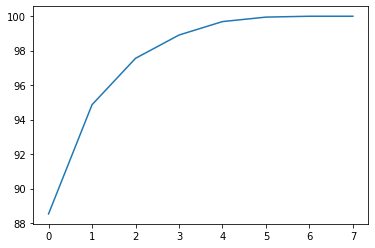

In [36]:
from sklearn.decomposition import PCA
# df["Sepssis"] = np.where(df["Sepssis"].str.contains("Positive"), 1, 0)
pca = PCA(n_components=8)
pca.fit(X)
#The amount of variance that each PC explains
var= pca.explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

plt.plot(var1)

# Models Development

**Miscelleous codes**

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from imblearn.pipeline import Pipeline as ImPipeline

In [27]:
def draw_confusion_matrix(cnf_matrix):
    class_names=["Positive","Negative"] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [28]:
def print_evaluate_score(y_test, y_pred):
    cnf = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred))
    draw_confusion_matrix(cnf)

In [29]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate

from sklearn import model_selection
def print_cross_validate(model):
    scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)

    results = model_selection.cross_validate(estimator=model,
                                            X=X,
                                            y=Y,
                                            cv=kfold,
                                            scoring=scoring, return_train_score=False)
                                            
    print("F1-score: %.3f"%results["test_f1_score"].mean())
    print("Accuracy score: %.3f"%results["test_accuracy"].mean())
    print("Recall score: %.3f"%results["test_recall"].mean())

In [30]:
from sklearn.metrics import confusion_matrix,f1_score, classification_report
from sklearn.model_selection import train_test_split


def print_hold_out_evaluation(model, X, Y):
# spliting
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=6, test_size=0.2)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print_evaluate_score(y_test, pred)


## 1. Logistic Regression

In [31]:
# use polynomial to improve model fitting
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
poly = PolynomialFeatures(degree=1)

# instantiate the model (using the default parameters)
solver = "liblinear"
lr_model = LogisticRegression(C=1, solver= solver, 
max_iter=7000, tol=0.01,
penalty="l1", random_state=4)

scaler = RobustScaler()

lr_pipe = Pipeline(steps=[("poly",poly),
                            ("scaler",scaler),
                            ("logistic",lr_model)])

In [33]:
# SearchGrid CV
from sklearn.model_selection import GridSearchCV, RepeatedKFold
param_grid = {
    "logistic__C":np.logspace(-1, 2, 10),
    "logistic__class_weight": ["balanced"],
    "logistic__penalty":["l1","l2"],
    "poly__degree":[1,2,3,4]

}
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=4)
search = GridSearchCV(lr_pipe, param_grid, scoring="f1",cv=cv)
search.fit(X_over, Y_over)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.760):
{'logistic__C': 10.0, 'logistic__class_weight': 'balanced', 'logistic__penalty': 'l1', 'poly__degree': 3}


In [37]:
# logistic__C = search.best_params_["logistic__C"]
# logistic__class_weight = search.best_params_["logistic__class_weight"]
# logistic__penalty = search.best_params_["logistic__penalty"]
# poly_degree = search.best_params_["poly__degree"]
# best_logisticReg = LogisticRegression(
#     penalty= logistic__penalty,
#     C= logistic__C,
#     class_weight=logistic__class_weight,
#     random_state=4,
#     solver= solver,
#     max_iter=7000
# )
# poly = PolynomialFeatures(degree=poly_degree)

best_logisticReg = LogisticRegression(
    penalty= "l1",
    C= 10,
    class_weight="balanced",
    random_state=4,
    solver= solver,
    max_iter=7000
)
poly = PolynomialFeatures(degree=3)
print(best_logisticReg)

LogisticRegression(C=10, class_weight='balanced', max_iter=7000, penalty='l1',
                   random_state=4, solver='liblinear')


In [38]:
best_logistic_pipe = Pipeline(steps=[("poly",poly),("scaler", scaler), ("model",best_logisticReg)])

              precision    recall  f1-score   support

           0       0.82      0.73      0.77        81
           1       0.54      0.67      0.60        39

    accuracy                           0.71       120
   macro avg       0.68      0.70      0.68       120
weighted avg       0.73      0.71      0.71       120



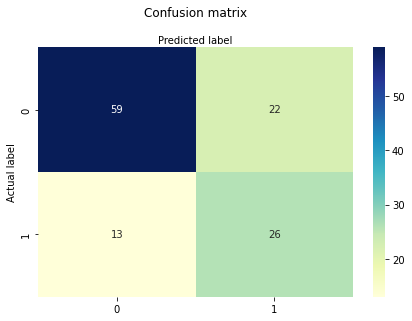

In [39]:
print_hold_out_evaluation(best_logistic_pipe, X, Y)

In [40]:
print_cross_validate(best_logistic_pipe)


F1-score: 0.610
Accuracy score: 0.714
Recall score: 0.644


## 2. Decision Tree

In [43]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline


dtree_model = DecisionTreeClassifier(max_features="sqrt", random_state=4, ccp_alpha=0.0032)
steps = [('model', dtree_model)]
dtree_pipe = Pipeline(steps=steps)

In [44]:
from sklearn.model_selection import RepeatedKFold, GridSearchCV
param_grid = {
    "model__class_weight": [{0:0.4,1:0.6}, {0:0.42,1:0.58},{0:0.45,1:0.55},{0:0.5,1:0.5}],
    "model__ccp_alpha": np.logspace(-3,1,10),
    "model__max_depth": [2,3,4],
    "model__min_samples_leaf": [1,2,3,4,5],

}
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=4)
search = GridSearchCV(dtree_pipe, param_grid, scoring="f1",cv=cv, error_score="raise")
search.fit(X_over, Y_over)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.761):
{'model__ccp_alpha': 0.007742636826811269, 'model__class_weight': {0: 0.4, 1: 0.6}, 'model__max_depth': 4, 'model__min_samples_leaf': 5}


In [106]:
# b_params = search.best_params_
# model__class_weight = b_params["model__class_weight"]
# model__ccp_alpha = b_params["model__ccp_alpha"]
# model__max_depth = b_params["model__max_depth"]
# model__min_samples_leaf = b_params["model__min_samples_leaf"]

# dtree_model = DecisionTreeClassifier(max_features="sqrt",
# class_weight=model__class_weight, 
# random_state=4, 
# ccp_alpha=model__ccp_alpha,
# max_depth=model__max_depth,
# min_samples_leaf=model__min_samples_leaf)

dtree_model = DecisionTreeClassifier(max_features="sqrt",
class_weight={0: 0.4, 1: 0.6}, 
random_state=4, 
ccp_alpha=0.007742636826811269,
max_depth=4,
min_samples_leaf=5)

steps = [('model', dtree_model)]

dtree_pipe = Pipeline(steps=steps)


              precision    recall  f1-score   support

           0       0.87      0.74      0.80        81
           1       0.59      0.77      0.67        39

    accuracy                           0.75       120
   macro avg       0.73      0.75      0.73       120
weighted avg       0.78      0.75      0.76       120



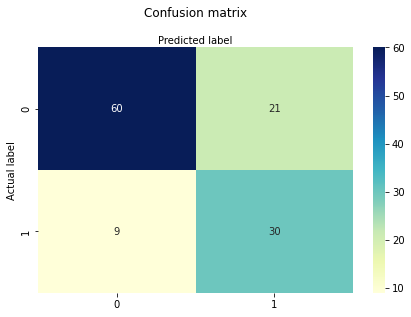

In [107]:
print_hold_out_evaluation(dtree_pipe, X, Y)

In [47]:
print_cross_validate(dtree_pipe)

F1-score: 0.626
Accuracy score: 0.698
Recall score: 0.734


## 4. Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(max_features="sqrt",random_state=3,class_weight={0:0.22, 1: 0.78}, n_jobs=-1)

In [49]:
from sklearn.model_selection import RepeatedKFold, GridSearchCV
param_grid = {
    "n_estimators": [100,150,200],
    # "class_weight": [{0:0.4,1:0.6}, {0:0.42,1:0.58},{0:0.45,1:0.55},{0:0.5,1:0.5}],
    "class_weight": ["balanced"],
    "ccp_alpha": np.logspace(-3,1,5),
    "max_depth": [2,3],
    "min_samples_leaf": [1,3,5],
    "min_samples_split": [2,3,4,5]

}
cv = RepeatedKFold(n_splits=10, n_repeats=2, random_state=4)
search = GridSearchCV(rf_model, param_grid, scoring="roc_auc",cv=cv, error_score="raise")
search.fit(X_over, Y_over)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.796):
{'ccp_alpha': 0.001, 'class_weight': 'balanced', 'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 200}


In [109]:
# b_params = search.best_params_
# n_estimators = b_params["n_estimators"]
# class_weight = b_params["class_weight"]
# ccp_alpha = b_params["ccp_alpha"]
# max_depth = b_params["max_depth"]
# min_samples_leaf = b_params["min_samples_leaf"]
# min_samples_split = b_params["min_samples_split"]

# rf_model = RandomForestClassifier(max_features="sqrt",
#                             random_state=3,
#                             class_weight=class_weight, 
#                             ccp_alpha= ccp_alpha,
#                             max_depth= max_depth,
#                             min_samples_leaf= min_samples_leaf,
#                             min_samples_split= min_samples_split,
#                             n_jobs=-1)

rf_model = RandomForestClassifier(max_features="sqrt",
                            random_state=3,
                            class_weight="balanced", 
                            ccp_alpha= 0.001,
                            max_depth= 3,
                            min_samples_leaf= 1,
                            n_jobs=-1)

              precision    recall  f1-score   support

           0       0.86      0.73      0.79        81
           1       0.57      0.74      0.64        39

    accuracy                           0.73       120
   macro avg       0.71      0.74      0.72       120
weighted avg       0.76      0.73      0.74       120



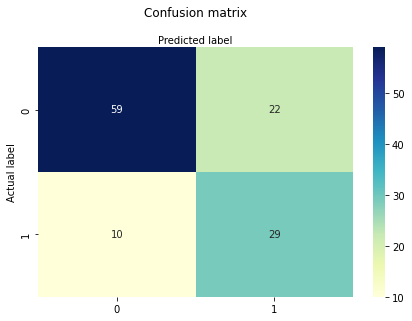

In [110]:
print_hold_out_evaluation(rf_model, X, Y)


In [111]:
print_cross_validate(rf_model)

F1-score: 0.672
Accuracy score: 0.746
Recall score: 0.749


## 5. Boosting


In [53]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=250, learning_rate=0.5, max_depth=1, random_state=0, tol=0.001)


In [58]:
from sklearn.model_selection import RepeatedKFold, GridSearchCV
param_grid = {
    "n_estimators": [100,200, 300],
    "learning_rate": [0.1,0.5,1],
    "max_depth": [1,2,3],
    "ccp_alpha": np.logspace(-3,1,5),
    "max_features": ["sqrt"],
    "min_samples_split": [2,3],
    "tol": [0.001],

}
cv = RepeatedKFold(n_splits=10, n_repeats=2, random_state=4)
search = GridSearchCV(clf, param_grid, scoring="roc_auc",cv=10, error_score="raise")
search.fit(X_over, Y_over)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.789):
{'ccp_alpha': 0.001, 'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300, 'tol': 0.001}


In [112]:
clf = GradientBoostingClassifier(
        n_estimators=300, 
        learning_rate=0.1, 
        max_depth=3, 
        random_state=0, 
        max_features="sqrt",
        min_samples_split=2,
        ccp_alpha=0.001,
        tol=0.001)


              precision    recall  f1-score   support

           0       0.85      0.83      0.84        81
           1       0.66      0.69      0.68        39

    accuracy                           0.78       120
   macro avg       0.75      0.76      0.76       120
weighted avg       0.79      0.78      0.78       120



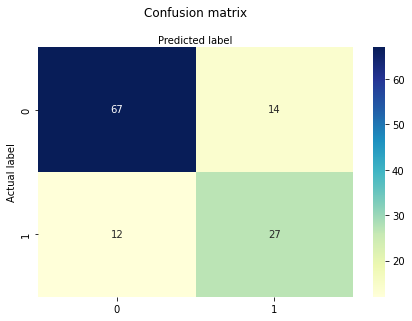

In [113]:
print_hold_out_evaluation(clf, X, Y)

In [114]:
print_cross_validate(clf)

F1-score: 0.622
Accuracy score: 0.766
Recall score: 0.561
